In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/3_ovals"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from utils import *
from Dataloader import *
from PSFNetv2 import *

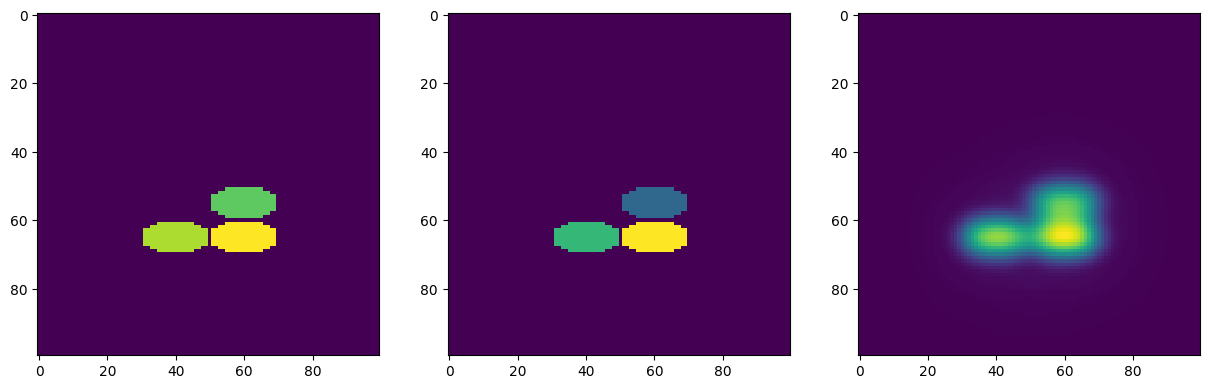

In [3]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
maskSize = EuclideanDistance((0,0),mask.shape)
sourcePts = GetSourcePts(mask,FOLDER)

#Define dataset and dataloader
dataset = Dataloader(out, mask, adjPts=4, randomPts=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

#Define model
model = PSFNet(len(sourcePts),dataset.intensityMatrix.data.flatten())

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0)


In [6]:
#Training loop

timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"
oldOut = out.copy()

TrainingLoop(model,dataloader,criterion,optimizer,epochs=10)

oldOut = InverseMatrix(oldOut,mask,sourcePts,learningRate=1,randomPts=0,adjPts=0,model=model)
oldOut = oldOut/max(oldOut.flatten())

print('Finished Training')


Epoch:  10  Loss:  41799.6923828125
[0.3333333333333333, 0.6666666666666666, 1.0]
[[-0.33865368]
 [ 0.25853262]
 [ 1.        ]]
Finished Training


In [7]:
print(model.polynomial_weights.weight.data)

tensor([[-22.9078]])


In [8]:
model.polynomial_weights.weight.data[0] = -1000

/tmp/ipykernel_225578/2611858017.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  new_psf_y = model.getPSF(torch.tensor(new_psf_x))


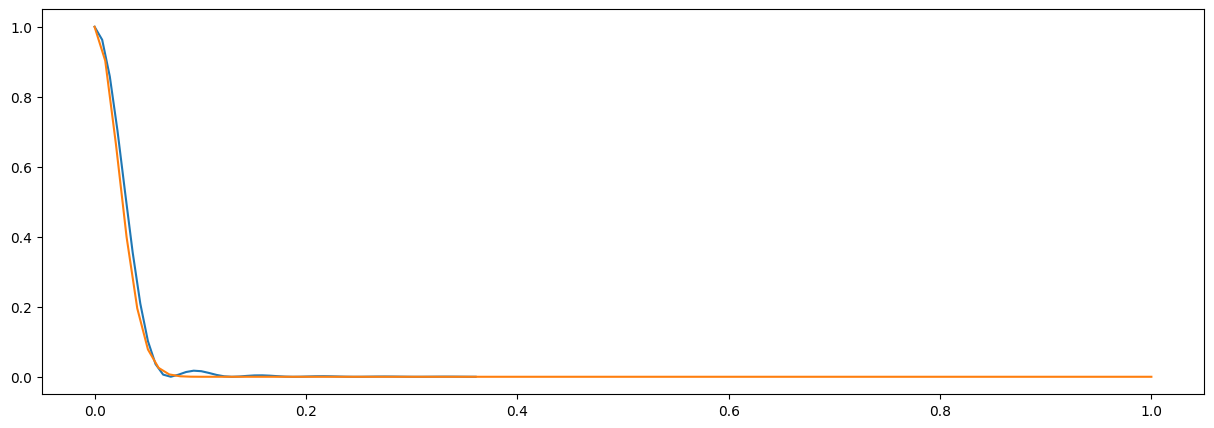

In [9]:
#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
new_psf_y = new_psf_y/max(new_psf_y.flatten())
plt.plot(new_psf_x,new_psf_y)
plt.show()


In [10]:
oldOut = InverseMatrix(oldOut,mask,sourcePts,model,learningRate=1,randomPts=0,adjPts=0)
oldOut = oldOut/max(oldOut.flatten())

TypeError: InverseMatrix() got multiple values for argument 'learningRate'

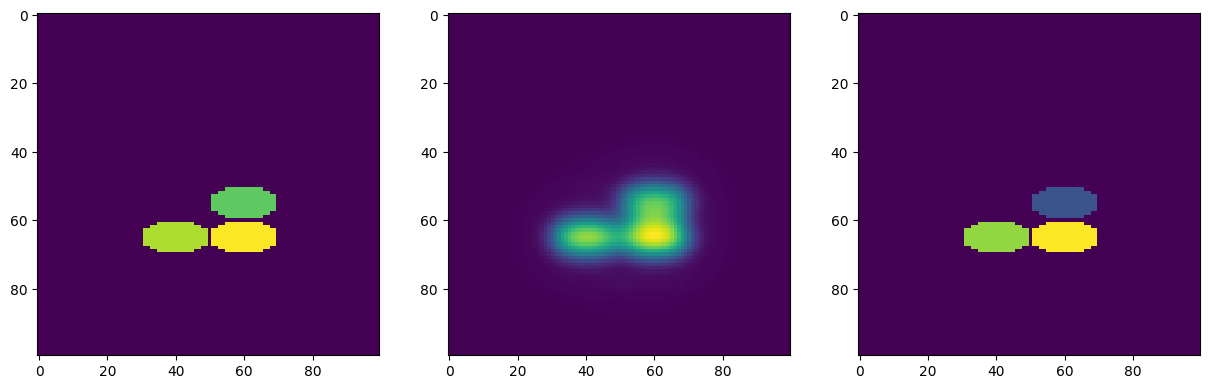

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(oldOut)
plt.show()


array([[1.        , 0.95027051],
       [0.95027051, 1.        ]])

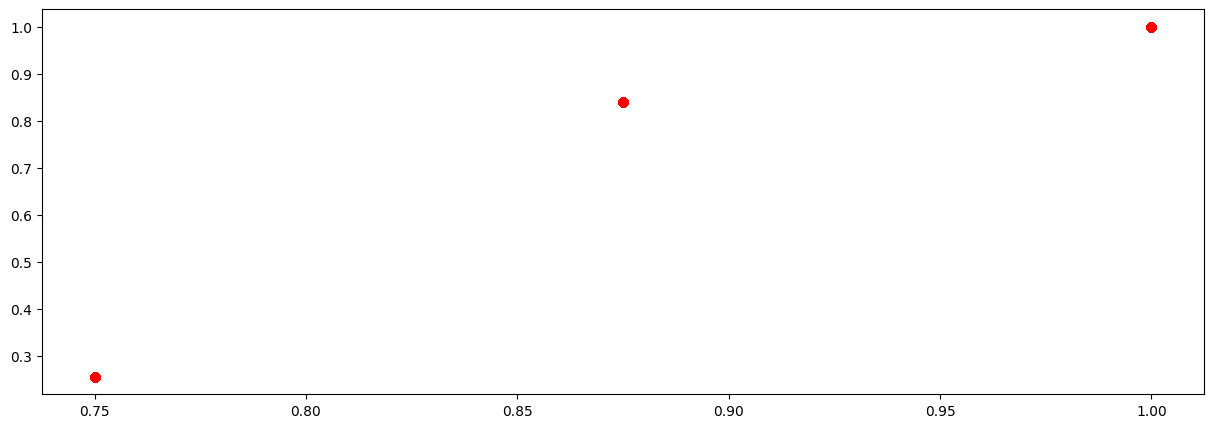

In [ ]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(oldOut[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)